# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [28]:
# Are we using a GPU?
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [29]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data from the course github
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close


--2022-03-12 08:14:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   135MB/s    in 1.2s    

2022-03-12 08:14:11 (135 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



<bound method ZipFile.close of <zipfile.ZipFile filename='10_food_classes_10_percent.zip' mode='r'>>

In [30]:
# How many images in each folder?
import os

# Walk thorugh 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/c

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerato`class to load our images into batches

In [31]:
# Setup data inputs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks(things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the **TensorBoard** callback
* Model checkpoint with the **ModelCheckpoint** callback
* Stopping a model from training (before it trains too long and overfits) with the **EarlyStopping** callback

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks


In [32]:
# Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

🔑**Note:** You can curstomize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir`parameter we've created above is only one option

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on : https://tfhub.dev/

Browsing the TensorFlow Hub pahe and sorting for image classification, we found the following feature vector model link:
https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [33]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [34]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [35]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [36]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to nymber of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [37]:
# Create resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [38]:
# Compiler our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [39]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [40]:
train_data_10_percent.num_classes

10

In [42]:
# Let's fit our ResNet model to the data (10 percent of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorboard_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorboard_hub/resnet50V2/20220312-081419
Epoch 1/5
24/24 [==============================] - 445s 19s/step - loss: 1.8142 - accuracy: 0.4000 - val_loss: 1.1169 - val_accuracy: 0.6548
Epoch 2/5
24/24 [==============================] - 488s 21s/step - loss: 0.8703 - accuracy: 0.7600 - val_loss: 0.8249 - val_accuracy: 0.7376
Epoch 3/5
24/24 [==============================] - 432s 19s/step - loss: 0.5923 - accuracy: 0.8400 - val_loss: 0.7253 - val_accuracy: 0.7636
Epoch 4/5
24/24 [==============================] - 481s 21s/step - loss: 0.4680 - accuracy: 0.8800 - val_loss: 0.6931 - val_accuracy: 0.7772
Epoch 5/5
24/24 [==============================] - 424s 18s/step - loss: 0.3680 - accuracy: 0.9147 - val_loss: 0.6631 - val_accuracy: 0.7816


Our transfer lerning feature extractor model out performed ALL of the prevous models we built by hand... (substantially) and in a quicker training time AND with only 10% of the training examples.

In [43]:
# Let's create a function to plot our loss curves
# Tidbit: you could put a function like this into a script called "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TenssorFlow History object.
  
  Returns:
    Plots of training/validation loss and accuracy metrics
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();


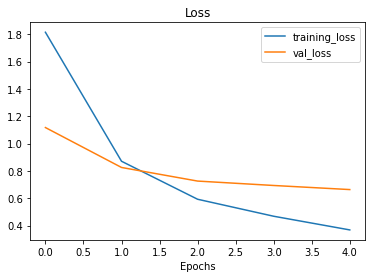

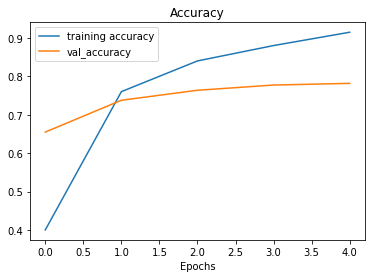

In [45]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [46]:
# Creating EfficientNetB0 feature extractor model
efficientnet_model = create_model(model_url=efficientnet_url, 
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorboard_hub",
                                                                                     experiment_name="efficientnetb0")])

Saving TensorBoard log files to: tensorboard_hub/efficientnetb0/20220312-090201
Epoch 1/5
24/24 [==============================] - 194s 8s/step - loss: 1.8449 - accuracy: 0.4613 - val_loss: 1.3163 - val_accuracy: 0.7268
Epoch 2/5
24/24 [==============================] - 182s 8s/step - loss: 1.0669 - accuracy: 0.7933 - val_loss: 0.8679 - val_accuracy: 0.8180
Epoch 3/5
24/24 [==============================] - 177s 8s/step - loss: 0.7578 - accuracy: 0.8413 - val_loss: 0.6998 - val_accuracy: 0.8376
Epoch 4/5
24/24 [==============================] - 183s 8s/step - loss: 0.6087 - accuracy: 0.8613 - val_loss: 0.6130 - val_accuracy: 0.8520
Epoch 5/5
24/24 [==============================] - 173s 7s/step - loss: 0.5154 - accuracy: 0.8893 - val_loss: 0.5585 - val_accuracy: 0.8612


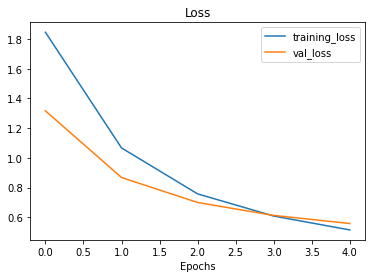

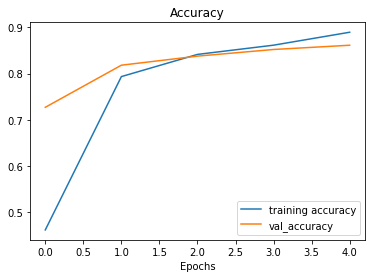

In [47]:
plot_loss_curves(efficientnet_history)

In [48]:
efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [49]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [55]:
# How many layers does our efficientnetb0 feature extractor have?
print(efficientnet_model.layers)
len(efficientnet_model.layers[0].weights) # .returns a list of matrices, one matrix of weights for each layher inside the pretrained layer (efficientNetB0)

[<tensorflow_hub.keras_layer.KerasLayer object at 0x7f33a8d00510>, <keras.layers.core.dense.Dense object at 0x7f33a61b67d0>]


309

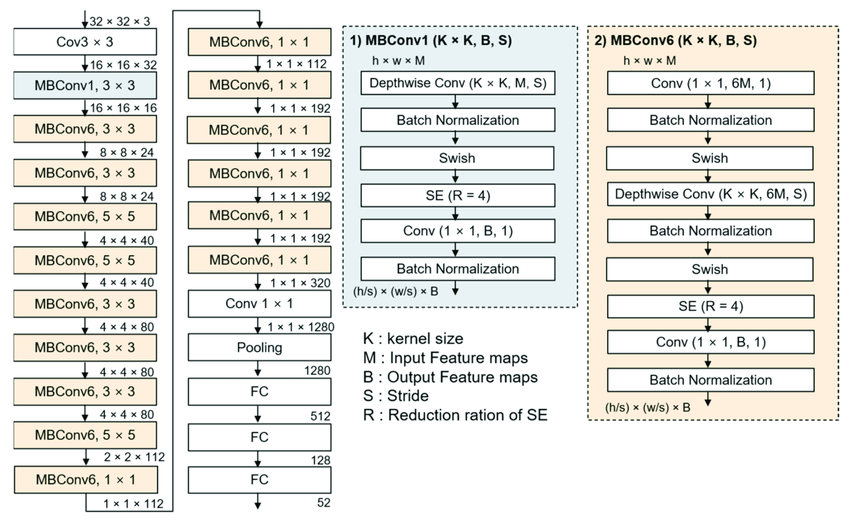

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (e.g. using ImageNet model on 1000 ImageNet classes, none of your own)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (e.g. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

https://tensorboard.dev/

>🔑**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want others to see) do not upload them to TensorBoard.dev

In [58]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorboard_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction model architectures using 10% of the training data" \
  --one_shot

2022-03-12 09:40:31.603558: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorboard_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf

Our TensorBoard experiments are uploaded publicly here https://tensorboard.dev/experiment/Qen9WhlFRcGalz6WI8yqUg/

In [59]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2022-03-12 09:45:28.004447: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
https://tensorboard.dev/experiment/Qen9WhlFRcGalz6WI8yqUg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction model architectures using 10% of the training data
	Id                   Qen9WhlFRcGalz6WI8yqUg
	Created              2022-03-12 09:41:12 (4 minutes ago)
	Updated              2022-03-12 09:41:14 (4 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5796427
Total: 1 experiment(s)


In [60]:
# Delete an experiment
!tensorboard dev delete --experiment_id Qen9WhlFRcGalz6WI8yqUg

2022-03-12 09:46:55.842991: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Deleted experiment Qen9WhlFRcGalz6WI8yqUg.


In [61]:
# Confirm the deletion by re-checking what experiments you have left
!tensorboard dev list

2022-03-12 09:47:07.602892: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No experiments. Use `tensorboard dev upload` to get started.
